# Neural Network Regression with Prediction Confidence

If you are a data scientist then making a model that outputs a numeric value - a.k.a. a regression -  is a piece of cake. But very often we are not interested only in the predicted _value_ but also in the _uncertainty around that value_. This article will take you through a simplistic example where we learn how to predict a value together with a confidence estimate. We'll use Python and tf.keras. Notebook is available [here](https://gitlab.com/Emmanuel_B/whats-up-timeseries/-/blob/master/notebooks/predict-confidence.ipynb)!

The **classical approach** is to evaluate the model's output on all of the training input and compute the _average error rate_ according to one's favorite metric. Let's talk concretely: imagine you are predicting the temperature tomorrow and your model has an average error rate of 5%, then if your model says tomorrow temparature will be 30 degrees you just add +- 5% to this number to get a confidence interval.

Now this is not perfect for a number of reason. The main issue here is that we use an averaged error estimation which does not depend on the data point. What if the model is sometimes very certain for certain inputs? For example if you are dead in the rainy season the model might be 99% sure that it will be raining tomorrow and the 5% error rate is way too much. On the other hand there might be some days where the model is much more uncertain than the average and the 5% might get you in trouble.
In summary, you have understood my point. Computing an average error rate is well... an average. It does not take into account the particularities of the actual point you are predicting.

Let's improve this. What if the model itself could output not just a single predicted value but also _its confidence_? In that way you would get a confidence estimation that would be tailored to the actual data point you are predicting -  full context awareness. We all know that in business situations knowing the uncertainty about the estimation is just as important as the actual prediction.

In this short tutorial I'm going to show you how to make a very simple neural networks that does regression with uncertainty estimation. In order to make it as simple as possible I'm going to reduce the complexity totaly: I'll use dummy 1 dimensional data and 1 a single layer network. Now rest assured that the same method will work on real, complex data. For those of you who want to see this kind of method in a "real" setting check out this great research article: [DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks](https://arxiv.org/abs/1704.04110).

Now let's get into it. Here's the plan:

1.  We'll generate dummy data with a varying uncertainty
1.  We'll make a very simple classical regression model and show the "naive" confidence intervals
1.  Finally we'll improve that model so that it outputs its confidence

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from relu_me import rangetest
from matplotlib import pyplot as plt

In [3]:
n_samples = 100
n_neurons = 10
np.random.seed(42)
# plt.style.use("dark_background")

In [4]:
# Utils
def viz_history(lr, loss, figsize=(9, 9/1.6)):
    """ Visualizes training history.
    
    Args:
       lr (1D float): Learning rates per epoch.
       loss (1D float): Loss per epoch.
       figsize (tuple): Size of the figure.
       
    """
    _, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)
    ax1.plot(lr)
    ax1.set_title('Learning rate schedule')
    ax1.set_ylabel('learning rate')
    ax2.plot(loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('loss')
    plt.show()

## Our Dummy Data

We generate two variables. `x` is our independant variable it takes values between 0 and 1. `y` is the value we actually want to predict.

Now we generate the data so that $y = x + \mathcal{N}(0, x/5)$. Let's break this down. It means that y is pretty much equal to x. So a very very simple prediction indeed!! However the _uncertainty_ on y grows linearly with x. So if you have a small x you are pretty much sure that y=x but for larger x values y starts to spread around the expected value x.

In [5]:
x = np.random.uniform(0.1, 1, size=n_samples)
y = np.random.normal(loc=x, scale=x/5)

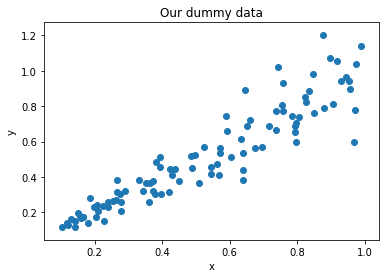

In [6]:
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Our dummy data")
None

## First "naive" regression model

Let's make a neural network that predicts `y` based on `x`. We'll just use a single layer neural network. Let's use keras for this:

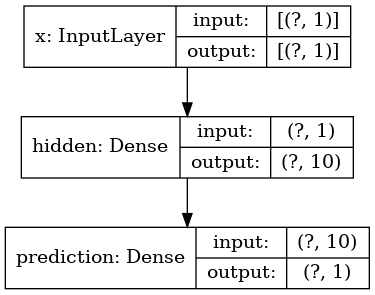

In [7]:
inputs = keras.layers.Input(shape=(1,), name="x")
hidden_layer = keras.layers.Dense(10, name="hidden")(inputs)
prediction_out = keras.layers.Dense(1, name="prediction")(hidden_layer)
naive_model = keras.Model(inputs=inputs, outputs=prediction_out)
keras.utils.plot_model(naive_model, show_shapes=True)

It doesn't get simpler than this!

Let's use MSE loss and train this model:

In [8]:
naive_model.compile(loss="mse", optimizer='adam', batch_size=n_samples)
naive_model.fit(x=x, y=y, epochs=200, verbose=0)

Our model has trained for 200 epochs, let's show the results:

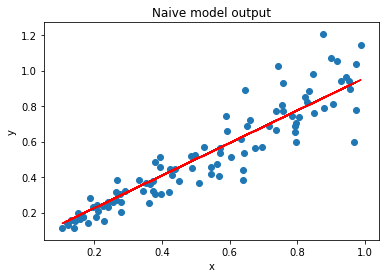

In [9]:
y_predict = naive_model.predict(x)
plt.plot(x, y_predict, color='r', label='predicted')
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Naive model output")
None

Ok so this is pretty much the prediction that we expected. Our model correctly predicts y=x. Let's see what is the average error:

In [10]:
mse = metrics.mean_squared_error(y, y_predict)
print("Average mean squared error:", mse)
print("95% CI:", mse*1.96)

Average mean squared error: 0.010877796683092553
95% CI: 0.021320481498861406


Assuming the model error is Gaussian, we can use this MSE error to compute confidence intervals. The details use some properties of the Gaussian distribution that we won't really need right now, so let's just use the following formula which gives us a 95% confidence interval (CI):
$$CI = \hat y \pm 1.96 \times \sqrt{MSE} = \hat y \pm 0.019$$

Using this formula on our naive model and graphically showing the results gives the graph below. As you can see the CI is correct in that we do have roughly 95% of our data points in the predicted interval. But it completely misses the variability in the noisiness of the data.

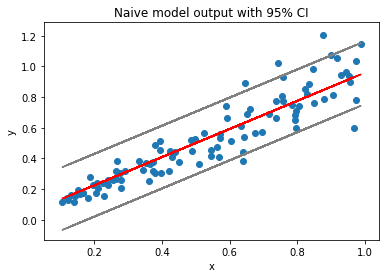

In [11]:
y_predict = naive_model.predict(x)
plt.plot(x, y_predict, color='r', label='predicted')
plt.plot(x, y_predict + 1.96*np.sqrt(mse), color='grey', label='predicted')
plt.plot(x, y_predict - 1.96*np.sqrt(mse), color='grey', label='predicted')

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Naive model output with 95% CI")
None

## Adding confidence information to model output

As promised we are going to modify our model so that it output not just one prediction but a prediction together with its confidence.

This is the time to get technical. In order to talk about the confidence in the prediction we need to talk about the _distribution_ of its values. Depending of the data you have, the distribution you expect might differ. In our example we clearly have a normal distribution because that is how we generated our data, but that is not mandatory. How do you know which distribution is relevant for your project? Plot the data and look at the following characteristics: number of modes, symmetry around the mean, data range. According to these parameters you should find a distribution that matches what you need.

Now there is a reason I chose the normal distribution for this toy example. It is the default distribution to use and it should be a good place to start if you are dealing with real valued data. So let's proceed with this example.

A normal distribution is defined by 2 parameters: $\mu$ the mean and $\sigma$ the standard variation. From these two values we can compute all the confidence intervals we need. So let's just make our network output this 2 values. This is quite straightforward:


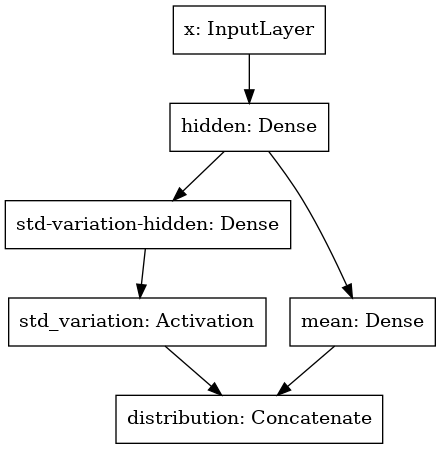

In [81]:
keras.backend.clear_session()
confidence_model = None
inputs = keras.layers.Input(shape=(1,), name="x")
hidden_layer = keras.layers.Dense(10, name="hidden", activation="relu")(inputs)
mean_out = keras.layers.Dense(1, name="mean")(hidden_layer)
hidden2 = keras.layers.Dense(1, name="std-variation-hidden")(hidden_layer)
std_out = keras.layers.Activation("relu", name="std_variation")(hidden2)
distrib_out = keras.layers.concatenate([mean_out, std_out], name="distribution")
confidence_model = keras.Model(inputs=inputs, outputs=distrib_out)
keras.utils.plot_model(confidence_model)

Quite straightforward again! The only thing to note about this model is that I used a "relu" activation for the _standard variation_ output. Why? This is because standard variation must be positive!

Now we need to __select a loss function__ for the model. Before we used a mean squared error that just penalized the prediction error. But here we need a way to penalize both the prediction and the uncertainty.

For this we are going to write our problem in terms of probabilistic terms. Our model takes a x as input and outputs a normal probability distribution $\mathcal{N}(\mu(x), \sigma(x))$. Our training is successful if this distribution matches the actual data distribution. How to quantify "matching the actual distribution"? Well we'll say that it is a good match if the probability to get our exact training data if we were to draw from our distribution is high. Makes sense?

For a data point (x, y) the probability of having y being sampled from $\mathcal{N}(\mu(x), \sigma(x))$ is given by:

$$P(y|\mu, \sigma) = {1 \over  \sigma \sqrt{2 \pi}} \exp{(y-\mu)^2 \over 2 \sigma^2}$$

This is just the probability density function of the Gaussian law. Now we want to make this probability as high as possible, that is we want to find the functions $\mu(x), \sigma(x)$ that maximises $P(y|\mu(x), \sigma(x))$.

Now there are a couple of fun computations ahead:
-   We are going to apply the logarithm since maximizing P is the same as maximizing $\ln(P)$
-   We are going to drop constants since they don't play a role in the optimization
-   We will negate the whole thing. This is just because keras likes to _minimize_ things and if we minimize the negative it is just like maximixing the original.

Finally we get our loss that we can use:

$$\mathrm{loss}(y, \sigma, \mu) = \ln(\sigma) + {(y-\mu)^2 \over 2 \sigma^2}$$

Is this a valid loss? You can check that it makes sense. It combines our target values y together with the networks outputs $\sigma, \mu$. Also we can make sense of each term individually:
-   $\ln(\sigma)$ this will be low for small $\sigma$ which _pushes the network to be confident_.
-   ${(y-\mu)^2 \over 2 \sigma^2}$ will be low for high $\sigma$ and low $(y-\mu)^2$. This will push the network to have little prediction error.
-   Since one term wants to push the confidence up and one wants to push it down what will happen is that the network should find a sweetspot so that it is neither too confident nor too conservative.

Ok that is it for the theory. Let's implement this as a keras custom loss.

In [82]:
def confidence_loss(y_true, distrib_pred):
    """ Negative log likelihood loss for normal distribution.
    
    Args:
        y_true: Ground truth values, of shape (batch_size, 1).
        distrib_pred: The predicted values, of shape (batch_size, 2).

    Returns:
        Tensor of shape (batch_size,)
    """
    eps = 1e-3
    mus = distrib_pred[:, 0]
    sigmas = distrib_pred[:, 1] + eps # avoid log(0)
    ans = tf.math.log(sigmas)
    ans += (y_true[:,0] - mus)**2/2/sigmas**2
    return ans

In [83]:
def test_custom_loss():
    """ Tests our loss on special values. """
    np.testing.assert_array_almost_equal(
        confidence_loss(tf.convert_to_tensor([[0]], dtype="float32"),
                        tf.convert_to_tensor([[0, 1]], dtype="float32")),
        0, decimal=2)
    
    np.testing.assert_array_almost_equal(
        confidence_loss(tf.convert_to_tensor([[0], [0]], dtype="float32"),
                        tf.convert_to_tensor([[0, 1], [0, 1]], dtype="float32")),
        [0,0], decimal=2,
        err_msg="confidence_loss should return vector output")

    np.testing.assert_array_almost_equal(
        confidence_loss(tf.convert_to_tensor([[0]], dtype="float32"),
                        tf.convert_to_tensor([[1, 1]], dtype="float32")),
        0.5, decimal=2)
    
test_custom_loss()

Ok let's train this model!

In [84]:
confidence_model.compile(loss=confidence_loss, optimizer="adam")

# this will hold training metrics
cumulated_loss = []
cumulated_lr = []

In [91]:
range_test = rangetest.lr_range_test(
    confidence_model, x, y,
    base_lr=0.000001, max_lr=1, n_steps=200, batch_size=n_samples)


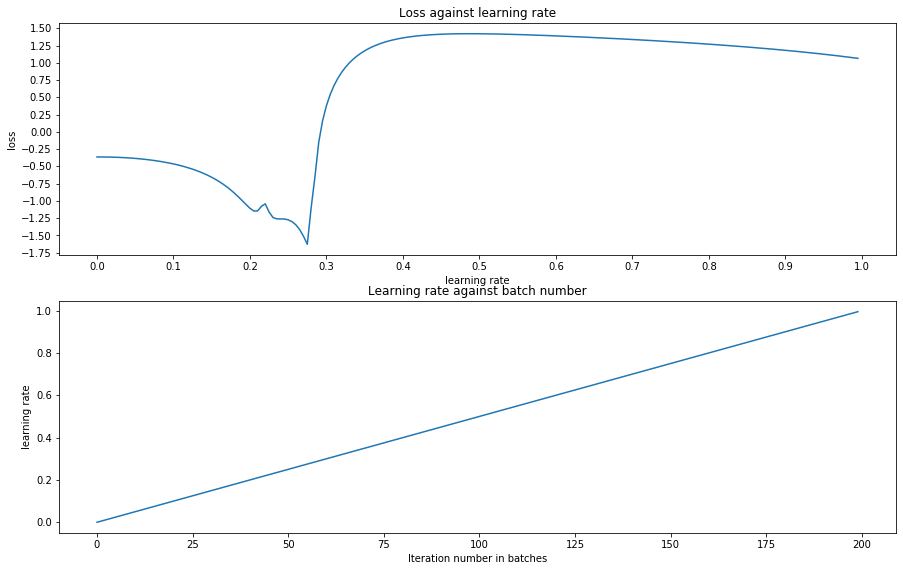

In [93]:
rangetest.show_lr_range_test(range_test, None)

In [94]:

# clr = rangetest.CyclicLR(base_lr=0.001, max_lr=0.01, step_size=250*n_pixels // batch_size, mode="triangular2")

confidence_model.optimizer.learning_rate = 0.1
history = confidence_model.fit(x=x,y=y, epochs=100, batch_size=n_samples)

Train on 100 samples
Epoch 1/100
100/100 [==============================] - 0s 185us/sample - loss: -0.3624
Epoch 2/100
100/100 [==============================] - 0s 46us/sample - loss: -0.3652
Epoch 3/100
100/100 [==============================] - 0s 62us/sample - loss: -0.3690
Epoch 4/100
100/100 [==============================] - 0s 44us/sample - loss: -0.3736
Epoch 5/100
100/100 [==============================] - 0s 52us/sample - loss: -0.3789
Epoch 6/100
100/100 [==============================] - 0s 54us/sample - loss: -0.3850
Epoch 7/100
100/100 [==============================] - 0s 69us/sample - loss: -0.3917
Epoch 8/100
100/100 [==============================] - 0s 51us/sample - loss: -0.3992
Epoch 9/100
100/100 [==============================] - 0s 46us/sample - loss: -0.4074
Epoch 10/100
100/100 [==============================] - 0s 63us/sample - loss: -0.4163
Epoch 11/100
100/100 [==============================] - 0s 42us/sample - loss: -0.4259
Epoch 12/100
100/100 [========

In [95]:
# save the history for these epochs
# I typically run the last few cells (range test + training + this one) a few times until I get to around -1.9 loss.
cumulated_loss += history.history['loss']
cumulated_lr += [confidence_model.optimizer.learning_rate.numpy()]*len(history.history['loss'])

Training this model is a little bit more fiddly than the previous one. Here's the way I do it:
1.  I use a [learning rate range test](https://www.machinecurve.com/index.php/2020/02/20/finding-optimal-learning-rates-with-the-learning-rate-range-test/) to select a learning rate.
1.  I train for 100 epochs with this learning rate
1.  I check the loss, if it is lower than -1.9 I stop, otherwise I go back to step 1

Usually this method works in a few hundreds epochs. Note that about 50% of the time it converges to a bad local minimum. In that case just reinitialize the model and restart.

Below we have a sample training curves where I only had to do two iterations of the above procedure. As you see I started with a learning rate of 0.01 then moved to 0.1.

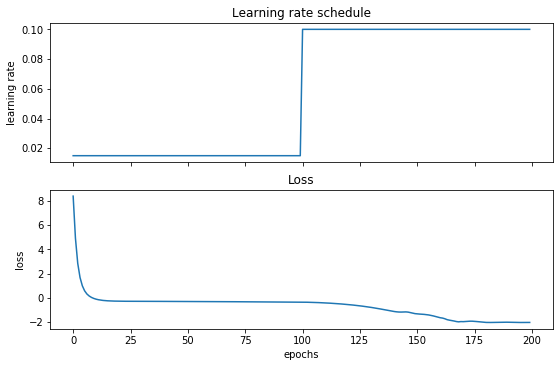

In [96]:
viz_history(cumulated_lr, cumulated_loss)

Ok now our model is trained so this is the time to do the final reveal (I know the suspens is unbearable). We're going to plot our model results. For this:

1.  We use the first output $\mu$ as the prediction
1.  We use the second output $\sigma$ to build the 95% CI according to the formula $CI = \mu \pm 1.96\times \sigma$

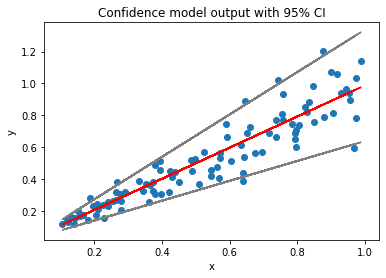

In [98]:
y_predict = confidence_model.predict(x)
mus = y_predict[:,0]
sigmas = y_predict[:, 1]
plt.plot(x, mus, color='r', label='predicted')
plt.plot(x, mus + 1.96*sigmas, color='grey', label='predicted')
plt.plot(x, mus - 1.96*sigmas, color='grey', label='predicted')

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Confidence model output with 95% CI")
None

That's it. As you can see our model is correctly more confident for small x values.

## Conclusion

In this article we've seen how to make predictions together with an uncertainty estimate. We've looked at the theory and the implementation in Keras.

From a practical point of view you only need to change your loss function to the one I've shown you to upgrade your models to probabilistic predictions.

Finally, what about using real data? Again this was a very watered down example to give you a quick idea of the method. Check out [DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks](https://arxiv.org/abs/1704.04110) where they apply a more sophisticated version of this technique to get uncertainty estimates for sales forecasts.

I came up this method while reading precisely this article and I thought the method was cool enough to make it a simple example. I haven't tried it on a real dataset yet. Do let me know your thoughts!